<a href="https://colab.research.google.com/github/MarkusThill/techdays25/blob/feature-lab2-initial-draft/notebooks/lab2-model-quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Lab 2: Effiziente Quantisierung tiefer neuronaler Netze

Strukturierung:
- Teil 1: Darstellung numerischer Datentypen
- Teil 2:
  - Quantisierung des einfachen Modells aus Lab 1
  - Diverse Betrachtungen auf dem quantisierten Modell (Genauigkeit, etc.)
  - Gotchas (Optional): Overflow/Underflow am Beispiel eines Average Pooling layers
  - ...
- Teil 3: Quantisierung eines DTMF Klassifikationsmodells
  - Illustration: Erzeugung einer DTMF Wählsequenz und Abspielen derselben
  - Laden eines vortrainierten DTMF-Klassifikationsmodells (ConvNet; Keras oder PyTorch)
  - Konvertierung nach ONNX
  - Quantisierung nach FP16
  - Messung der Inferenzzeiten (auch für verschiedene Batch-Sizes) und vergleich von FP32, FP16-Modell
  - Vergleich der Genauigkeit von FP16 und FP32 Modell (wie ändert sich die Fehlerrate)
  - Optional: Konvertierung nach FP8 und Wiederholung der obigen Schritte
  - Optional: Profiling der ONNX Modelle. Wo liegen die "Hotspots" des Modells?
  - Optional: Trainieren des Modells auf de


# Vorbereitungen: Installation der nötigen Abhängigkeiten

In [1]:
# Remove the `%%capture`, if you have the impression that something is going wrong during the setup
%%capture
!pip install "techdays25[lab2] @ git+https://github.com/MarkusThill/techdays25.git@main"

**WICHTIG: Nach der Installation der Abhängigkeiten (siehe oben) muss die Google Colab Laufzeit neugestartet werden! Im Anschluss kann mit der Ausführung der nächsten Zellen fortgefahren werden werden.**

In [1]:
# @title Some Colab-Specific Configuration {display-mode: "form"}
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import output

    output.enable_custom_widget_manager()

## 📘 Einleitung
- DTMF
- Quanstisierungsansätze
- etc.

## 📖 Wiederholung: Darstellung numerischer Datentypen (Optional)
- Zweierkomplementdarstellung
- IEEE-754 Standard

### Ganzahldarstellungen/Zweierkomplementdarstellung

In [2]:
# @title Darstellung von 16-Bit Integer Zahlen {display-mode: "form"}

import ipywidgets as widgets
from IPython.display import HTML

# Initialize 8 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="40px")
    )
    for _ in range(8)
]

# Output widget to show results
output = widgets.Output()


def twos_complement(bits: list[int]) -> int:
    """Convert list of bits to signed integer using two's complement.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        int: The signed integer value of the binary number.
    """
    if bits[0] == 0:
        return int("".join(str(b) for b in bits), 2)
    # If MSB is 1, it's negative
    inverted_bits = [1 - b for b in bits]  # Flip bits
    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
    return -incremented


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Hex representation (2 hex digits for 8 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binary: <code>{bit_string}</code><br>
            Unsigned Decimal: <b>{unsigned_decimal}</b><br>
            Signed Decimal (Two's Complement): <b>{signed_decimal}</b><br>
            Hexadecimal: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.HBox(bit_toggles))
display(output)

# Initialize display
update_display()

Output()

#### Übungsfragen (Optional):
- Grundlegendes Setzen von Bits: Setze das 3. Bit (von rechts) einer 8-Bit-Zahl auf 1 und alle anderen Bits auf 0. Was ist die dezimale Darstellung dieser Zahl im unsigned Format?
Erwartete Antwort: 4

- Setzen mehrerer Bits: Setze das 1., 3. und 5. Bit (von rechts) einer 8-Bit-Zahl auf 1 und alle anderen Bits auf 0. Was ist die dezimale Darstellung dieser Zahl im unsigned Format?
Erwartete Antwort: 21

- Was ist die größtmögliche bzw. kleinstmögliche Zahl die mit 8 Bit dargestellt werden können? Antwort: -128, +127
  - Was wäre die Antwort, wenn wir statt 8-bit Integer, nun 32-bit Integer haben?

- Signed vs. Unsigned Darstellung: Setze das 8. Bit (höchstwertiges Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -128, Unsigned: 128

- Was charakterisiert eine negative Zahl in der Zweierkomplementdarstellung (unsigned integer) im Allgmeinen? Antwort: Zumindest das vorderste Bit ist gesetzt.

- Wie negiere ich eine Zahl (z.B. 32 -> -32 bzw. -71 -> 71)? Antwort: Invertieren alle Bits und Addition  von 1

- Angenommen ich habe -33 als 8-bit Zahl vorliegen. Wie würde ich daraus eine 32-bit unsigned Integer Zahl machen? Antwort: Einfach noch drei Bytes voranhängen in denen alle Bits gesetzt sind.

- Kombinieren von Bits: Setze das 2., 4. und 6. Bit (von rechts) einer 8-Bit-Zahl auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: 42, Unsigned: 42

- Negative Zahlen in der Signed-Darstellung: Setze das 8. Bit (höchstwertiges Bit) und das 1. Bit (niederwertigstes Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -127, Unsigned: 129

- Maximale und minimale Werte: Was ist der maximale Wert, den man mit einer 8-Bit unsigned Zahl darstellen kann? Was ist der minimale Wert, den man mit einer 8-Bit signed Zahl darstellen kann?
Erwartete Antwort: Maximale unsigned: 255, Minimale signed: -128

- Bitmuster und Werte: Setze die Bits, um die Binärzahl 10101010 zu bilden. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -86, Unsigned: 170

- Alle Bits gesetzt: Setze alle Bits einer 8-Bit-Zahl auf 1. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -1, Unsigned: 255


- Verständnis von Überlauf: Was passiert, wenn du 1 zum maximalen Wert einer 8-Bit unsigned Zahl hinzufügst? Was passiert bei einer 8-Bit signed Zahl?
Erwartete Antwort: Bei unsigned wird es auf 0 zurückgesetzt. Bei signed verursacht es einen Überlauf und wird auf den minimalen Wert (-128) zurückgesetzt.
Zweierkomplement:

- Erkläre, wie die Zweierkomplement-Darstellung für negative Zahlen in einer 8-Bit signed Zahl funktioniert.
Erwartete Antwort: Im Zweierkomplement ist das höchstwertige Bit (MSB) das Vorzeichenbit. Um das Zweierkomplement einer Zahl zu finden, invertiere alle Bits und addiere 1 zum niederwertigsten Bit (LSB).

### Fixkommadarstellungen

In [3]:
# @title Darstellung von 16-Bit Festkomma-Zahlen (engl.: fixpoint binary representations) {display-mode: "form"}
import ipywidgets as widgets

# Initialize 16 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, integer part, and fractional part
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 7
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show results
output = widgets.Output()


# def twos_complement(bits):
#    """Convert list of bits to signed integer using two's complement."""
#    if bits[0] == 0:
#        return int("".join(str(b) for b in bits), 2)
#
#    # If MSB is 1, it's negative
#    inverted_bits = [1 - b for b in bits]  # Flip bits
#    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
#    return -incremented


def fixed_point_value(bits: list[int]) -> float:
    """Convert a list of bits to a fixed-point value.

    Args:
        bits (list[int]): A list of 16 bits representing the binary number in fixed-point format.

    Returns:
        float: The fixed-point value of the binary number.
    """
    integer_part = bits[:8]
    fractional_part = bits[8:]

    # Calculate integer value
    integer_value = twos_complement(integer_part)

    # Calculate fractional value
    fractional_value = sum(
        bit * 2 ** (-i) for i, bit in enumerate(fractional_part, start=1)
    )

    return integer_value + fractional_value


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Fixed-point value
    fixed_point_decimal = fixed_point_value(bit_values)

    # Hex representation (4 hex digits for 16 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binary: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:8]}</span>.
                <span style="color: blue;">{bit_string[8:]}</span>
            </code><br>
            Unsigned Decimal: <b>{unsigned_decimal}</b><br>
            Signed Decimal (Two's Complement): <b>{signed_decimal}</b><br>
            Fixed-Point Decimal: <b>{fixed_point_decimal}</b><br>
            Hexadecimal: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars)]))
display(output)

# Initialize display
update_display()

Output()

#### Übungsfragen (Optional):

### Fließkommadarstellungen nach IEEE-754
- TODO: Subnormal Numbers
- Webseite mit noch mehr Darstellungen: https://evanw.github.io/float-toy/
- Verschiedene FP8-Darstellungen: https://asawicki.info/articles/fp8_tables.php
- https://onnx.ai/onnx/technical/float8.html

In [4]:
# @title Darstellung von 16-Bit (FP16) Fließkomma-Zahlen {display-mode: "form"}

import struct

import ipywidgets as widgets
import numpy as np

# from IPython.display import display

# Initialize 16 toggle buttons (bits)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, exponent, and mantissa
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 5
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show FP16 value and components
output = widgets.Output()


def bits_to_float16(bits: list[int]) -> np.float16:
    """Convert list of bits to FP16 float value.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        np.float16: The FP16 float value of the binary number.
    """
    bit_string = "".join(str(b) for b in bits)
    # Convert binary string to integer
    int_value = int(bit_string, 2)
    # Pack as unsigned 16-bit int, then unpack as float16 using numpy
    packed = struct.pack("<H", int_value)  # Big endian 16-bit unsigned int
    return np.frombuffer(packed, dtype=np.float16)[0]


def update_display(*args):
    """Update the display with the current binary, FP16 float value, and its components."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Extract components
    sign = bit_values[0]
    exponent_bits = bit_values[1:6]
    mantissa_bits = bit_values[6:]

    exponent = int("".join(str(b) for b in exponent_bits), 2)
    exponent_unbiased = exponent - 15  # Bias = 15

    mantissa_raw = "".join(str(b) for b in mantissa_bits)
    (
        1 + sum(int(b) * 2 ** (-i) for i, b in enumerate(mantissa_bits, start=1))
        if exponent != 0
        else 0
    )

    # Convert to float16 value
    fp16_value = bits_to_float16(bit_values)

    # Clear previous output and display new info
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binary: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:6]}</span>
                <span style="color: blue;">{bit_string[6:]}</span>
            </code><br>
            Sign (1 bit): <b>{sign}</b> ({"-" if sign else "+"})<br>
            Exponent (5 bits): <b>{"".join(str(b) for b in exponent_bits)} (biased: {exponent}, unbiased: {exponent_unbiased})</b><br>
            Mantissa (10 bits): <b>{mantissa_raw}</b><br>
            <hr>
            <b>FP16 Value:</b> {fp16_value}
        </h3>
        """)
        )

    # Update button labels
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars)]))
display(output)

# Initialize output
update_display()  # 0 01111 0000000001 ^=^ 1.00097656

Output()

#### Übungsfragen (Optional):
- Gibt es einen Unterschied zwischen +0.0 und -0.0?
- Wie stelle ich `+Inf` bzw. `-Inf` dar?
- Wie stelle ich `NaN` dar?
- Was ergibt der Vergleich `float("nan") != float("nan")`?

# Case Study 1: Quantisierung eines einfachen Modells (aus Lab 1)
- Gotchas: zu große, kleine inputs, numerische Abweichungen. Ggfs.: Sehr kleines Gewicht, sehr großer Input.

# Case Study 2: Klassifizierung von DTMF (dual-tone multi-frequency) Wählsignalen

## Einführung: Generierung und Dekodierung von Dual Tone Multiple Frequency (DTMF)-Signalen <a class="anchor" id="part0"></a>


Das Dualton-Mehrfrequenzwahlverfahren (DTMF) ist ein Signalisierungssystem für das Wählen eines Telefons, das in den frühen 1960er Jahren von Western Electric entwickelt und später von Bell System kommerziell an Telefonkunden geliefert wurde.
Wenn eine Taste auf dem Telefon gedrückt wird, werden zwei harmonische Tonsignale erzeugt, und die Superposition/Überlagerung beider Signale wird verwendet, um die entsprechende Telefontaste zu charakterisieren. Wenn zum Beispiel die Taste „5“ gedrückt wird, entsteht ein Dualtontonsignal, das sich aus den Frequenzen 770 Hz und 1336 Hz zusammensetzt. Die beiden Frequenzen, die jede Taste beschreiben, sind in der folgenden Tabelle aufgeführt:

|   | 1209Hz  | 1336 Hz  | 1477 Hz   | 1633 Hz  |
|---|:---:|:---:|:---:|:---:|
| **697 Hz**  |  1 | 2  | 3  | A  |
| **770 Hz**  |  4 | 5  | 6  | B  |
| **852 Hz**  |  7 | 8  | 9  | C  |
| **941 Hz**  |  * | 0  | #  | D  |

In diesem Beispiel werden wir uns ansehen, wie man solche DTMF-Wählsequenzen generiert, sie in einer Audiodatei speichert und das Audiosignal mit einem einfachen KI-Modell wieder dekodiert.

Wir werden die folgenden Schritte durchführen, um ein DTMF-Signal zu erzeugen und zu dekodieren:
1. Erzeugung des Signals und der Audiodatei mit `scipy` und `numpy`. Wir speichern die erzeugte Audiodatei in einer `.wav` Datei, die in diesem Notebook oder in deinem lokalen Audioplayer abgespielt werden kann
2. Wir entwerfen eine einfaches KI-Modell ... TODO
3. Extraktion der gewählten Tastenfolge aus der `.wav`-Datei unter Verwendung des KI-Modells
4. Quantisierung & Export des Modells nach ONNX im FP32 und FP16 Format
5. Laufzeit Untersuchungen für FP16/FP32, unterschiedliche Batch-Größen und Signallängen.

In [ ]:
# Trainiere Modell
# Konvertiere Modell nach ONNX (einmal FP32, einmal FP16)
# Untersuche Laufzeitunterschiede (auch nach batchsize)
# Untersuche Abweichungen. Wie ändert sich die Fehlerrate des Modells für FP32/Fp16?

## Signal and Audio File Generation <a class="anchor" id="part1"></a>

In [ ]:
# Make sure the following packages are installed

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

In [ ]:
# Mostly based on:
# https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
# Used to add some noise the the DTMF signal
def fftnoise(f):
    """_summary_.

    Args:
        f (_type_): _description_

    Returns:
        _type_: _description_
    """
    rng = rng = np.random.default_rng()
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = rng.random(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real


def band_limited_noise(min_freq, max_freq, samples, samplerate=44100):
    """_summary_.

    Args:
        min_freq (_type_): _description_
        max_freq (_type_): _description_
        samples (_type_): _description_
        samplerate (int, optional): _description_. Defaults to 44100.

    Returns:
        _type_: _description_
    """
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs >= min_freq, freqs <= max_freq))[0]
    f[idx] = 1
    nn = fftnoise(f)
    A = np.iinfo(np.int32).max * 10
    return A * nn


def get_key_tone(key: str, samplerate=44100, dur=0.4):
    """_summary_.

    Args:
        key (str): _description_
        samplerate (int, optional): _description_. Defaults to 44100.
        dur (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    key = key.upper()
    matrix = np.array([
        "1",
        "2",
        "3",
        "A",
        "4",
        "5",
        "6",
        "B",
        "7",
        "8",
        "9",
        "C",
        "*",
        "0",
        "#",
        "D",
    ]).reshape(4, 4)
    freqz_cols = [1209, 1336, 1477, 1633]
    freqz_rows = [697, 770, 852, 941]
    if len(key) != 1:
        return None
    if key not in matrix:
        return None
    r_idx, c_idx = np.where(matrix == key)
    f1 = freqz_rows[int(r_idx)]
    f2 = freqz_cols[int(c_idx)]

    # Create signal with both frequencies
    tt = np.arange(0.0, dur, 1 / samplerate)
    A = np.iinfo(np.int32).max / 4
    return A * (np.sin(2.0 * np.pi * f1 * tt) + np.sin(2.0 * np.pi * f2 * tt))

In [ ]:
def get_tone_sequence(key_sequence: str, samplerate=44100, dur_key=0.4, dur_pause=0.4):
    """_summary_.

    Args:
        key_sequence (str): _description_
        samplerate (int, optional): _description_. Defaults to 44100.
        dur_key (float, optional): _description_. Defaults to 0.4.
        dur_pause (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    global tones
    tones = [get_key_tone(c, samplerate=samplerate, dur=dur_key) for c in key_sequence]

    # Quit, if at least one of the keys was not found
    if (np.array(tones) is None).any():
        return None

    pause_signal = [0] * int(dur_pause * samplerate)
    tones_with_pauses = [pause_signal]
    for tone in tones:
        tones_with_pauses.extend([tone, pause_signal])

    signal = np.hstack(tones_with_pauses)

    # Finally, add some noise to the signal
    noise = band_limited_noise(min_freq=200, max_freq=10000, samples=signal.shape[0])
    return signal + noise

In [ ]:
samplerate = 44100
wav_file_name = "my_dtmf_file.wav"

# Either generate a random sequence:
# my_dialed_sequence = "".join([random.choice("1234567890ABCD*#") for i in range(50)])

# ... or use a simple sequence for debugging purposes
# my_dialed_sequence = "1234567890ABCD*#" # for debug purposes...

# ... or use a slightly longer sequence (which also contains all symbols)
my_dialed_sequence = "91D282A0B8C16C*C9#504979D#443B"

# Try changing the following arguments: dur_key=0.05, dur_pause=0.02
dial_signal = get_tone_sequence(
    my_dialed_sequence, samplerate=samplerate, dur_key=0.2, dur_pause=0.1
)
wavfile.write(wav_file_name, samplerate, dial_signal.astype(np.int32))

<ipython-input-18-771cdab29e37>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f1 = freqz_rows[int(r_idx)]
<ipython-input-18-771cdab29e37>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f2 = freqz_cols[int(c_idx)]


In [ ]:
dial_signal.shape

(401310,)

In [ ]:
# Now let us listen to the generated WAV file
import IPython

IPython.display.Audio(wav_file_name)

In [ ]:
print("Dialed sequence: ", my_dialed_sequence)
print("Used symbols: ", len(set(my_dialed_sequence)))
print("Total length of signal:", dial_signal.shape[0])

Dialed sequence:  91D282A0B8C16C*C9#504979D#443B
Used symbols:  16
Total length of signal: 538020


### Spectrogram of the signal

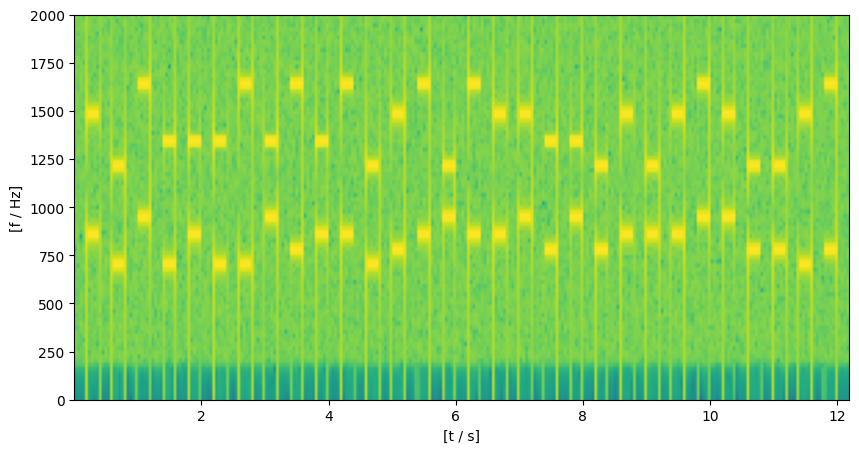

In [ ]:
plt.figure(figsize=(10, 5))
Pxx, freqs, bins, im = plt.specgram(dial_signal, NFFT=2048, Fs=samplerate)
plt.ylim(0, 2000)
plt.xlabel("[t / s]")
plt.ylabel("[f / Hz]")
plt.show(im)

In [ ]:
# @title Phone Dialer Widget {display-mode: "form"}

import ipywidgets as widgets

# from IPython.display import display

# Initialize a text widget to display the dial sequence
dial_sequence = widgets.Text(
    value="",
    placeholder="Dial sequence will appear here...",
    description="Dial Sequence:",
    disabled=True,
    layout=widgets.Layout(width="300px"),
)


# Function to handle button clicks
def on_button_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    dial_sequence.value += b.description


# Create buttons for the phone dialer
buttons = []
for row in [["1", "2", "3"], ["4", "5", "6"], ["7", "8", "9"], ["*", "0", "#"]]:
    button_row = []
    for label in row:
        button = widgets.Button(
            description=label, layout=widgets.Layout(width="50px", height="50px")
        )
        button.on_click(on_button_click)
        button_row.append(button)
    buttons.append(widgets.HBox(button_row))

# Create a clear button
clear_button = widgets.Button(
    description="Clear", layout=widgets.Layout(width="160px", height="50px")
)


def on_clear_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    dial_sequence.value = ""


clear_button.on_click(on_clear_click)

# Display the dialer
display(dial_sequence)
for button_row in buttons:
    display(button_row)
display(clear_button)

Text(value='', description='Dial Sequence:', disabled=True, layout=Layout(width='300px'), placeholder='Dial se…

Button(description='Clear', layout=Layout(height='50px', width='160px'), style=ButtonStyle())